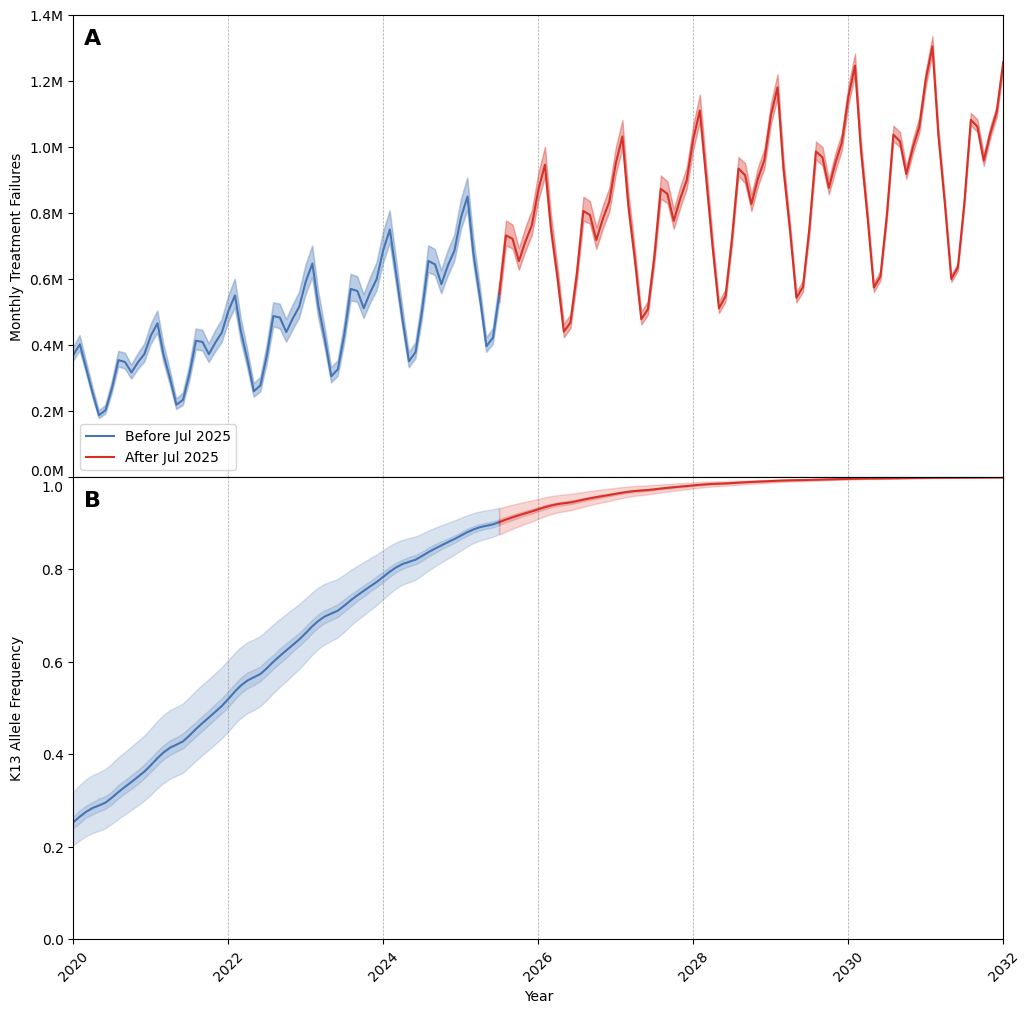

<Figure size 640x480 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import pandas as pd

# Adjust the y-axis to show values in millions
def millions_formatter(x, pos):
    return f'{x * 1e-6:.1f}M'  # Formats in millions with one decimal point

# Define the color palette for the two periods
cold_hot_palette = ['#4575b4', '#d73027']  # cold for 'Before Sep 2024', hot for 'After Sep 2024'

# Set xticks to display only years with a step of 2
locator = mdates.YearLocator(2)

# load the data
monthly_data = pd.read_csv('./data/fig3_data.csv')
data = monthly_data[monthly_data['scenario'] == 'status_quo']
data.loc[:, 'date'] = pd.to_datetime(data['date'])
# Convert the comparison date to a datetime object
comparison_date = pd.to_datetime('2012-01-01')
# Filter the data and create a copy to avoid SettingWithCopyWarning
filtered_data = data[data['date'] >= comparison_date].copy()

critical_point = pd.to_datetime('2025-07-01')

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), sharex=True)


# Plot 1: Monthly Treatment Failures Over Time
plot_data = filtered_data[ (filtered_data['date'] <= critical_point) ] 
sns.lineplot(ax=ax1, x='date', y='total_treatmentfailures', 
             data=plot_data,
             color=cold_hot_palette[0], legend=False, errorbar=("pi", 90), label='Before Jul 2025')

# Calculate quantiles for each date within this period
grouped_data = plot_data.groupby('date')['total_treatmentfailures']
quantiles_90 = grouped_data.quantile([0.05, 0.95]).unstack(level=-1)
quantiles_50 = grouped_data.quantile([0.25, 0.75]).unstack(level=-1)

# Plot shading for the 90% quantile range
ax1.fill_between(
    quantiles_90.index, quantiles_90[0.05], quantiles_90[0.95], 
    color=cold_hot_palette[0], alpha=0.2, 
)

# SECOND SEGMENT
plot_data = filtered_data[ (filtered_data['date'] >= critical_point) ]
sns.lineplot(ax=ax1, x='date', y='total_treatmentfailures',
             data=plot_data,
             color=cold_hot_palette[1], errorbar=("pi", 90),
             label="After Jul 2025")

# Calculate quantiles for each date within this period
grouped_data = plot_data.groupby('date')['total_treatmentfailures']
quantiles_90 = grouped_data.quantile([0.05, 0.95]).unstack(level=-1)
quantiles_50 = grouped_data.quantile([0.25, 0.75]).unstack(level=-1)

# Plot shading for the 90% quantile range
ax1.fill_between(
    quantiles_90.index, quantiles_90[0.05], quantiles_90[0.95], 
    color=cold_hot_palette[1], alpha=0.2, 
)

ax1.set_xlim([pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01")])
ax1.set_ylim([0, 1.4e6])
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly Treatment Failures')
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(millions_formatter))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax1.text(0.03, 0.97, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

yticks = ax1.get_yticks()
yticks = yticks[1:]  # Remove the first label
ax1.set_yticks(yticks)

# Plot 2: K13 Allele Frequency Over Time
plot_data = filtered_data[ (filtered_data['date'] <= critical_point) ]
sns.lineplot(ax=ax2, x='date', y='k13_frequency', data=plot_data, color=cold_hot_palette[0], legend=False)

# Calculate quantiles for each date within this period
grouped_data = plot_data.groupby('date')['k13_frequency']
quantiles_90 = grouped_data.quantile([0.05, 0.95]).unstack(level=-1)
quantiles_50 = grouped_data.quantile([0.25, 0.75]).unstack(level=-1)

# Plot shading for the 90% quantile range
ax2.fill_between(
    quantiles_90.index, quantiles_90[0.05], quantiles_90[0.95], 
    color=cold_hot_palette[0], alpha=0.2, 
)

# SECOND SEGMENT
plot_data = filtered_data[ (filtered_data['date'] >= critical_point) ]
sns.lineplot(ax=ax2, x='date', y='k13_frequency', data=plot_data, color=cold_hot_palette[1], legend=False)

# Calculate quantiles for each date within this period
grouped_data = plot_data.groupby('date')['k13_frequency']
quantiles_90 = grouped_data.quantile([0.05, 0.95]).unstack(level=-1)
quantiles_50 = grouped_data.quantile([0.25, 0.75]).unstack(level=-1)

# Plot shading for the 90% quantile range
ax2.fill_between(
    quantiles_90.index, quantiles_90[0.05], quantiles_90[0.95], 
    color=cold_hot_palette[1], alpha=0.2, 
)

ax2.set_xlim([pd.to_datetime("2020-01-01"), pd.to_datetime("2032-01-01")])
ax2.set_ylim([0, 1])
ax2.set_xlabel('Year')
ax2.set_ylabel('K13 Allele Frequency')
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='x', rotation=45)

# Add light vertical grid lines
ax2.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax2.text(0.03, 0.97, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Get the current y-ticks
yticks = ax2.get_yticks()

# Get current labels and modify the last one
yticks_labels = [item.get_text() for item in ax2.get_yticklabels()]
if yticks_labels:  # Ensure there are labels to modify
    yticks_labels[-1] = '0.0M\n1.0'

# Set fixed tick positions and modified labels
ax2.set_yticks(yticks)  # Ensure tick positions remain consistent
ax2.set_yticklabels(yticks_labels)

plt.subplots_adjust(hspace=0)  # Remove gaps between subplots
plt.show()

plt.savefig('figure_3.png', dpi=300)